# Calculate ERPs reliability

### Imports

In [3]:
import os
import sys
import re
import glob
import ast
import os.path as op
import pickle
import mne
import scipy
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp

from collections import defaultdict

from copy import deepcopy
import copy

import pygsp

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.utils import resample
from sklearn.covariance import GraphicalLassoCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression


from scipy.stats import pearsonr

from autoreject import AutoReject

from transformers import *

import warnings
warnings.filterwarnings("ignore")

---
## Load data

Loading EEG data and data from rumination questionnaire. By default create_df_data loads all info from given file but one can specify it by passing a list of desired labels from csv file.

In [4]:
dir_path = os.path.dirname(os.path.abspath(""))

In [5]:
tmin, tmax = -0.1, 0.6  # Start and end of the segments
signal_frequency = 256
random_state = 0

In [6]:
def create_df_data(
    test_participants=False,
    test_epochs=False,
    info_filename=None,
    info="all",
    personal=True,
):
    """Loads data for all participants and create DataFrame with optional additional info from given .csv file.

    On default, loads a train set: chooses only 80% of participants
    and for each of them chooses 80% of epochs.
    It will choose them deterministically.

    Participants with less than 10 epochs per condition are rejected.

    If test_participants is set to True, it will load remaining 20% of participants.
    If test_epochs is set to True, it will load remaining 20% of epochs.
    Test epochs are chronologically after train epochs,
    because it reflects real usage (first callibration and then classification).

    Parameters
    ----------
    test_participants: bool
        whether load data for training or final testing.
        If true load participants data for testing.
    test_epochs: bool
        whether load data for training or final testing.
        If true load epochs of each participants data for testing.
    info_filename: String | None
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters
    personal: bool
        whether a model will be both trained and tested on epochs from one person
        if false, person's epochs aren't split into test and train


    Returns
    -------
    go_nogo_data_df : pandas.DataFrame

    """
    print(os.path.abspath(""))
    dir_path = os.path.dirname(os.path.abspath(""))
    print(dir_path)
    header_files_glob = os.path.join(dir_path, "data/responses_100_600_sonata/*.vhdr")
    header_files = glob.glob(header_files_glob)

    header_files = sorted(header_files)
    go_nogo_data_df = pd.DataFrame()

    # cut 20% of data for testing
    h_train, h_test = train_test_split(header_files, test_size=0.3, random_state=0)
    
    print(f"train size: {len(h_train)} ; test size: {len(h_test)}")

    if test_participants:
        header_files = h_test
    else:
        header_files = h_train

    for file in header_files:
        #  load eeg data for given participant
        participant_epochs = load_epochs_from_file(file)

        # and compute participant's id from file_name
        participant_id = re.match(r".*GNG-(\d+).*", file).group(1)

        error = participant_epochs["error_response"]._data
        correct = participant_epochs["correct_response"]._data

        # exclude those participants who have too few samples
        if len(error) < 5 or len(correct) < 5:
            # not enough data for this participant
            continue

        # construct dataframe for participant with: id|epoch_data|response_type|additional info...
        participant_df = create_df_from_epochs(
            participant_id, participant_epochs, info_filename, info
        )
        print(participant_id)
        go_nogo_data_df = go_nogo_data_df.append(participant_df, ignore_index=True)

    return go_nogo_data_df

In [7]:
def create_df_from_epochs(id, participant_epochs, info_filename, info):
    """Create df for each participant. DF structure is like: {id: String ; epoch: epoch_data ; marker: 1.0|0.0}
    1.0 means correct and 0.0 means error response.
    Default info extracted form .csv file is 'Rumination Full Scale' and participants' ids.
    With this info df structure is like:
    {id: String ; epoch: epoch_data ; marker: 1.0|0.0 ; File: id ; 'Rumination Full Scale': int}

    Parameters
    ----------
    id: String
        participant's id extracted from filename
    correct: array
        correct responses' data
    error: array
        error responses' data
    info_filename: String
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters

    Returns
    -------
    participant_df : pandas.DataFrame

    """
    participant_df = pd.DataFrame()
    info_df = pd.DataFrame()

    # get additional info from file
    if info_filename is not None:
        if info == "all":
            rumination_df = pd.read_csv(info_filename, dtype={'Demo_kod': object})
        else:
            rumination_df = pd.read_csv(info_filename, usecols=["Demo_kod"] + info, dtype={'Demo_kod': object})
        info_df = (
            rumination_df.loc[rumination_df["Demo_kod"] == id]
            .reset_index()
            .drop("index", axis=1)
        )      
    epoch_df = pd.DataFrame({"id": [id], "epoch": [participant_epochs]}).join(
            info_df
        )
    participant_df = participant_df.append(epoch_df, ignore_index=True)

    return participant_df

In [8]:
def load_epochs_from_file(file, reject_bad_segments="auto", mask=None):
    """Load epochs from a header file.

    Args:
        file: path to a header file (.vhdr)
        reject_bad_segments: 'auto' means that bad segments are rejected automatically.

    Returns:
        mne Epochs

    """
    # Import the BrainVision data into an MNE Raw object
    raw = mne.io.read_raw_brainvision(file)

    # Construct annotation filename
    annot_file = file[:-4] + "vmrk"

    # Read in the event information as MNE annotations
    annotations = mne.read_annotations(annot_file)

    # Add the annotations to our raw object so we can use them with the data
    raw.set_annotations(annotations)

    # Map with response markers only
    # event_dict = {
    #     "Stimulus/RE*ex*1_n*1_c_1*R*FB": 10004,
    #     "Stimulus/RE*ex*1_n*1_c_1*R*FG": 10005,
    #     "Stimulus/RE*ex*1_n*1_c_2*R": 10006,
    #     "Stimulus/RE*ex*1_n*2_c_1*R": 10007,
    #     "Stimulus/RE*ex*2_n*1_c_1*R": 10008,
    #     "Stimulus/RE*ex*2_n*2_c_1*R*FB": 10009,
    #     "Stimulus/RE*ex*2_n*2_c_1*R*FG": 10010,
    #     "Stimulus/RE*ex*2_n*2_c_2*R": 10011,
    # }
    
    event_dict = {
        'Stimulus/RE*ex*1_n*1_c_1*R*FB': 10003,
        'Stimulus/RE*ex*1_n*1_c_1*R*FG': 10004,
        'Stimulus/RE*ex*1_n*1_c_2*R': 10005,
        'Stimulus/RE*ex*1_n*2_c_1*R': 10006,
        'Stimulus/RE*ex*2_n*1_c_1*R': 10007,
        'Stimulus/RE*ex*2_n*2_c_1*R*FB': 10008,
        'Stimulus/RE*ex*2_n*2_c_1*R*FG': 10009,
        'Stimulus/RE*ex*2_n*2_c_2*R': 10010,
    }

    # Map for merged correct/error response markers
    merged_event_dict = {"correct_response": 0, "error_response": 1}

    # Reconstruct the original events from Raw object
    events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

    # Merge correct/error response events
    merged_events = mne.merge_events(
        events,
        [10003, 10004, 10008, 10009],
        merged_event_dict["correct_response"],
        replace_events=True,
    )
    merged_events = mne.merge_events(
        merged_events,
        [10005, 10006, 10007, 10010],
        merged_event_dict["error_response"],
        replace_events=True,
    )

    epochs = []
    bads = []
    this_reject_by_annotation = False
    
    # Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=merged_events,
        event_id=merged_event_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=this_reject_by_annotation,
        preload=True,
    )
    
    ar = AutoReject(random_state=random_state, n_jobs=10, verbose=0)
    epochs_ar, reject_log = ar.fit_transform(epochs, return_log=True)

    # reject trials bad at Fz
    idx = reject_log.ch_names.index('Fz')
    mask = (reject_log.labels[:,idx] == 1)
    epochs_ar.drop(mask)
    
    print(f'Reject {len(np.where(mask == True)[0])} trials bad at Fz')    
    
    return epochs_ar

#### Read the data

In [9]:
def change_column_names(data_df):
    columns_dict = {
        "16-Rumination Full Scale": "RRQ", # mean
        "05-DASS-21 Anxiety scale": "DASS-21 Anx", # mean
        "05-DASS-21 Stress scale": "DASS-21 Stress", # mean
        "05-DASS-21 Depression scale": "DASS-21 Dep", # mean
        "04-STAI Trait MEAN": "STAI-T_M", # mean
        "04-STAI STATE 1-2 DIFFERENCE": "STAI-S Diff", # sum
        "number_error" : "uninhibited response", # sum
        "number_inhibited" : "inhibited response", # sum
        "04-STAI Trait SUM": "STAI-T", # sum
        "07-BIS": "BIS", # mean
        "14-Obsessive-Compulsive WASHING": "WASH", # mean
        "14-Obsessive-Compulsive OBSESSING": "OBSESS", # mean
        "14-Obsessive-Compulsive HOARDING": "HOARD", # mean
        "14-Obsessive-Compulsive ORDERING": "ORD", # mean
        "14-Obsessive-Compulsive CHECKING": "CHECK", # mean
        "14-Obsessive-Compulsive NEUTRALIZING": "NEU", # mean
        "18-Thought Suppression Inventory": "WBSI", # mean
        "28-Intolerance of Uncertainty - Prospective Anxiety": "IUS-P", # mean
        "28-Intolerance of Uncertainty - Inhibitory Anxiety": "IUS-I", # mean
        "06-Self-Esteem Scale_SES Rosenberga": "SES", # mean
        "07-BAS Dzialanie": 'BAS_D', # mean
        "07-BAS Poszukiwanie przyjemnosci": 'BAS_PRZY', # mean
        "07-BAS Wrazliwosc na nagrode": 'BAS_NAG', # mean
        "22-Nonforgiveness - Full Scale": 'NONFOR',
        "27-Indecisiveness Scale_Frost": 'INDEC_F', # mean
        "03-SP (Punishment Sensitivity)": 'PUN', # sum
        "03-SR (Reward Sensitivity)": 'REW', # sum
        "15-Obsessional Beliefs - Inflated responsibility for harm": 'HARM', # mean
        "15-Obsessional Beliefs - Importance/Control of Thoughts": 'T-CTR', # mean
        "15-Obsessional Beliefs - Overestimation of threat": "OT", # mean
        "15-Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty": 'OB_PERF', # mean
        "17-Perfectionism CMDA": 'CMDA', # mean
        "17-Perfect PS-Personal Standards (7 items mean)" : 'PS', # mean
        "19-Guilt sensitivity": 'G_SE', # mean
        "31-NFC Nietolerancja wieloznaczności-FULL": 'AMB', # mean
        "31-NFC Preferowanie przewidywalności-FULL": 'PRED', # mean
        "32-High standards from Maximization Full Scale" : 'STAND',   # mean
        "Wiek": "Age",
        "Płeć": "Sex",
        "Ręczność": "Handness",    

        #######
        "Rumination Full Scale": "RRQ",
        "DASS-21 Anxiety scale 0-SUM": "DASS-21 Anx", # sum
        "DASS-21 Stress scale 0-SUM": "DASS-21 Stress", # sum
        "DASS-21 Depression scale 0-SUM": "DASS-21 Dep", # sum
        "number_error": "uninhibited response", # sum
        "number_inhibited":  "inhibited response", # sum
        "STAI STATE 1-2 DIFFERENCE": "STAI-S Diff", # sum
        "STAI Trait SUM": "STAI-T", # sum
        "BIS": "BIS", # mean
        "Obsessive-Compulsive WASHING": "WASH", # mean
        "Obsessive-Compulsive OBSESSING": "OBSESS", # mean
        "Obsessive-Compulsive HOARDING": "HOARD", # mean
        "Obsessive-Compulsive ORDERING": "ORD", # mean
        "Obsessive-Compulsive CHECKING": "CHECK", # mean
        "Obsessive-Compulsive NEUTRALIZING": "NEU", # mean
        "Thought Suppression Inventory": "WBSI", # mean
        "Intolerance of Uncertainty - Prospective Anxiety": "IUS-P", # mean
        "Intolerance of Uncertainty - Inhibitory Anxiety": "IUS-I", # mean
        "Self-Esteem Scale_SES Rosenberga MEAN": "SES", # mean
        "BAS Dzialanie": 'BAS_D', # mean # drive
        "BAS Poszukiwanie przyjemnosci": 'BAS_PRZY', # mean # fun seeking
        "BAS Wrazliwosc na nagrode": 'BAS_NAG', # mean # responsivness
        "Indecisiveness Scale_Frost": 'INDEC_F', # mean
        "SP (Punishment Sensitivity)": 'PUN', # sum
        "SR (Reward Sensitivity)": 'REW', # sum
        "Obsessional Beliefs - Inflated responsibility for harm": 'HARM', # mean
        "Obsessional Beliefs - Importance/Control of Thoughts": 'T-CTR', # mean
        "Obsessional Beliefs - Overestimation of threat": "OT", # mean
        "Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty": 'OB_PERF', # mean
        "Perfect PS-Personal Standards (7 items mean)" : 'PS', # mean
        "Guilt sensitivity": 'G_SE', # mean
        "Nietolerancja wieloznaczności-FULL": 'AMB', # mean
        "Preferowanie przewidywalności-FULL": 'PRED', # mean
        "High standards from Maximization Full Scale" : 'STAND',   # mean
    }

    data_df = data_df.rename(columns=columns_dict)
    return data_df

- read Study 1 train data

In [10]:
# %%capture
df_name = "GNG_autoreject_3_5"
pickled_data_filename = "../data/" + df_name + ".pkl"
info_filename = "../data/scales/all_scales_with_rt.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_train_opus_df = pd.read_pickle(pickled_data_filename)
    epochs_train_opus_df.name = df_name
    epochs_train_opus_df = change_column_names(epochs_train_opus_df)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    epochs_train_opus_df = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_train_opus_df.name = df_name
    epochs_train_opus_df = change_column_names(epochs_train_opus_df)
    
    # save loaded data into a pickle file
    epochs_train_opus_df.to_pickle("../data/" + epochs_train_opus_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [11]:
epochs_train_opus_df.shape

(110, 188)

In [12]:
epochs_train_opus_df['STAI-T'] = epochs_train_opus_df['STAI-T'].apply(lambda x: x/20)

- read Study 2 train data

In [13]:
# %%capture
df_name = "GNG_autoreject_sonata_3_5_stai"
# df_name = "GNG_reject_auto_3-5"
pickled_data_filename = "../data/" + df_name + ".pkl"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_train_sonata_df = pd.read_pickle(pickled_data_filename)
    epochs_train_sonata_df.name = df_name
    epochs_train_sonata_df = change_column_names(epochs_train_sonata_df)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    epochs_train_sonata_df = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_train_sonata_df.name = df_name
    epochs_train_sonata_df = change_column_names(epochs_train_sonata_df)
    
    # save loaded data into a pickle file
    epochs_train_sonata_df.to_pickle("../data/" + epochs_train_sonata_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [14]:
epochs_train_sonata_df.shape

(150, 110)

Refine some data from questionnaries to reconcile data from two datasets

In [15]:
epochs_train_sonata_df.loc[epochs_train_sonata_df['Sex'] == 'Osoba niebinarna', 'Sex'] = 0.5

In [16]:
# normalize DASS-21 subscales scores to mean
epochs_train_sonata_df['DASS-21 Stress'] = epochs_train_sonata_df['DASS-21 Stress'].apply(lambda x: (x + 7)/7)
epochs_train_sonata_df['DASS-21 Anx'] = epochs_train_sonata_df['DASS-21 Anx'].apply(lambda x: (x + 7)/7)
epochs_train_sonata_df['DASS-21 Dep'] = epochs_train_sonata_df['DASS-21 Dep'].apply(lambda x: (x + 7)/7)

In [17]:
# normalize STAI state scale to mean (divide by amount of items in subscale)
epochs_train_sonata_df['STAI-T'] = epochs_train_sonata_df['STAI-T'].apply(lambda x: x/20)

In [18]:
# fill missing value in STAI-S Diff score
epochs_train_sonata_df.loc[epochs_train_sonata_df['STAI-S Diff'] == 'None', 'STAI-S Diff'] = None
epochs_train_sonata_df['STAI-S Diff'] = np.array(epochs_train_sonata_df['STAI-S Diff'].to_list()).astype(np.float) 

In [19]:
epochs_train_sonata_df['STAI-S Diff'] = epochs_train_sonata_df['STAI-S Diff'].fillna(epochs_train_sonata_df['STAI-S Diff'].mean())

#### Read data for external testing

- read Study 1 test

In [20]:
# %%capture
df_name = "GNG_autoreject_3_5_test_performance"
pickled_data_filename = "../data/" + df_name + ".pkl"
info_filename = "../data/scales/all_scales_with_rt.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_test_opus_df = pd.read_pickle(pickled_data_filename)
    epochs_test_opus_df.name = df_name
    epochs_test_opus_df = change_column_names(epochs_test_opus_df)
    print("Done")
else:
    print("Pickled file not found. Loading data...")
    epochs_test_opus_df = create_df_data(
        test_participants=True, info="all", personal=False, info_filename=info_filename
    )
    epochs_test_opus_df.name = df_name
    epochs_test_opus_df = change_column_names(epochs_test_opus_df)
    
    # save loaded data into a pickle file
    epochs_test_opus_df.to_pickle("../data/" + epochs_test_opus_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [21]:
epochs_test_opus_df.shape

(45, 164)

In [22]:
epochs_test_opus_df['STAI-T'] = epochs_test_opus_df['STAI-T'].apply(lambda x: x/20)

- read Study 2 test

In [23]:
# %%capture
df_name = "GNG_autoreject_sonata_3_5_test_stai"
pickled_data_filename = "../data/" + df_name + ".pkl"
info_filename = "../data/scales/Sonata_scales.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_test_sonata_df = pd.read_pickle(pickled_data_filename)
    epochs_test_sonata_df.name = df_name
    epochs_test_sonata_df = change_column_names(epochs_test_sonata_df)
    print("Done")
else:
    print("Pickled file not found. Loading data...")
    epochs_test_sonata_df = create_df_data(
        test_participants=True, info="all", personal=False, info_filename=info_filename
    )
    epochs_test_sonata_df.name = df_name
    epochs_test_sonata_df = change_column_names(epochs_test_sonata_df)
    
    # save loaded data into a pickle file
    epochs_test_sonata_df.to_pickle("../data/" + epochs_test_sonata_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [24]:
epochs_test_sonata_df.shape

(67, 110)

Refine some data from questionnaries to reconcile data from two datasets

In [25]:
epochs_test_sonata_df.loc[epochs_test_sonata_df['Sex'] == 'Osoba niebinarna', 'Sex'] = 0.5

In [26]:
# normalize DASS-21 subscales scores to mean
epochs_test_sonata_df['DASS-21 Stress'] = epochs_test_sonata_df['DASS-21 Stress'].apply(lambda x: (x + 7)/7)
epochs_test_sonata_df['DASS-21 Anx'] = epochs_test_sonata_df['DASS-21 Anx'].apply(lambda x: (x + 7)/7)
epochs_test_sonata_df['DASS-21 Dep'] = epochs_test_sonata_df['DASS-21 Dep'].apply(lambda x: (x + 7)/7)

In [27]:
# normalize STAI state scale to mean (divide by amount of items in subscale)
epochs_test_sonata_df['STAI-T'] = epochs_test_sonata_df['STAI-T'].apply(lambda x: x/20)

In [28]:
# fill missing value in STAI-S Diff score
epochs_test_sonata_df.loc[epochs_test_sonata_df['STAI-S Diff'] == 'None', 'STAI-S Diff'] = None
epochs_test_sonata_df['STAI-S Diff'] = np.array(epochs_test_sonata_df['STAI-S Diff'].to_list()).astype(np.float) 

In [29]:
epochs_test_sonata_df['STAI-S Diff'] = epochs_test_sonata_df['STAI-S Diff'].fillna(epochs_test_sonata_df['STAI-S Diff'].mean())

## Merge dataframes

In [30]:
opus_columns_list = epochs_train_opus_df.columns.to_list()
sonata_columns_list = epochs_train_sonata_df.columns.to_list()

columns = list(set(opus_columns_list) & set(sonata_columns_list))

In [31]:
epochs_train_sonata_df = epochs_train_sonata_df[columns]
epochs_train_opus_df = epochs_train_opus_df[columns]

epochs_test_sonata_df = epochs_test_sonata_df[columns]
epochs_test_opus_df = epochs_test_opus_df[columns]

Create train and test data

In [32]:
epochs_train_df = pd.concat([epochs_train_sonata_df, epochs_train_opus_df], ignore_index=True)
epochs_test_df = pd.concat([epochs_test_sonata_df, epochs_test_opus_df], ignore_index=True)

#### Chose dataset

In [59]:
test = True
dataset = 'test' if test else 'train'

In [60]:
epochs_df = epochs_train_df if not test else epochs_test_df

## Amplitude

### Within subject variability of CRN amplitude

In [ ]:
within_df = pd.DataFrame()
rois = [["Fz"],["FCz"], ["Cz"]]

for index, roi in enumerate(rois):
    pipeline_name = f'{roi[0]}'

    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    
    ern_pipeline = Pipeline([
            ("lowpass", BandpassFilter(h_freq=40.0)),
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("trim", EpochTrim(tmin=0, tmax=0.1)),
            ('extract_epoch_data', ExtractDataEpochs(condition='correct_response')),
            ("mean_amplitude", AverageSignal()),
    ])

    # for each person in dataset
    for index in range(0, len(epochs_df_copy)):
        data = epochs_df_copy.iloc[[index]] # df
        id_ = data['id'].to_list()
        personal_X = ern_pipeline.fit_transform(data) * 1000000
        personal_X = personal_X.reshape(-1,1)
        personal_variance = np.std(personal_X.flatten())

        data = pd.DataFrame({
            'pipeline' : pipeline_name,
            'id':id_,
            'personal variance' : personal_variance,
            'num_trials': len(personal_X),
        })

        within_df = pd.concat([within_df, data], ignore_index = True)

In [34]:
within_df.head()

,pipeline,id,personal variance,num_trials
0,Fz,024,11.945925,199
1,Fz,187,8.423905,217
2,Fz,132,6.669209,217
3,Fz,077,9.307314,212
4,Fz,154,8.429527,220


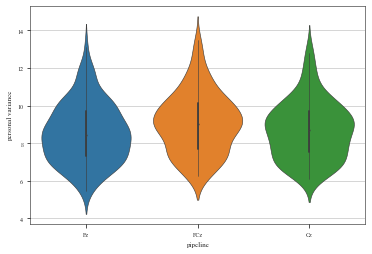

In [35]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('colorblind')

ax = sns.violinplot(
    x = 'pipeline', 
    y = 'personal variance', 
    data = within_df, 
    orient='v',  
    inner="box", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

In [36]:
within_df.groupby("pipeline").describe()

personal variance                                                    \
                     count      mean       std       min       25%       50%   
pipeline                                                                       
Cz                   112.0  8.702609  1.544903  6.073020  7.507194  8.709140   
FCz                  112.0  9.092303  1.614701  6.252234  7.677451  9.012060   
Fz                   112.0  8.533908  1.576240  5.466874  7.309380  8.429128   

                               num_trials                                      \
                75%        max      count        mean       std   min     25%   
pipeline                                                                        
Cz         9.716261  13.082310      112.0  211.107143  17.98666  82.0  207.75   
FCz       10.153513  13.491531      112.0  211.107143  17.98666  82.0  207.75   
Fz         9.691907  13.114533      112.0  211.107143  17.98666  82.0  207.75   

                               
            50%    75%    max  
pipeline                       
Cz        217.0  221.0  224.0  
FCz       217.0  221.0  224.0  
Fz        217.0  221.0  224.0

In [38]:
within_df.to_csv(f'../data/consistency_tests/{dataset}/crn_amplitude_within.csv')

### Between-subject variability of CRN amplitude

In [ ]:
between_df = pd.DataFrame()
rois = [["Fz"],["FCz"], ["Cz"]]

for index, roi in enumerate(rois):
    pipeline_name = f'{roi[0]}'

    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    
    ern_pipeline = Pipeline([
            ("lowpass", BandpassFilter(h_freq=40.0)),
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("trim", EpochTrim(tmin=0, tmax=0.1)),
            ("average", Evoked(condition='correct_response')),
            ('extract_epoch_data', ExtractData()),
            ("mean_amplitude", AverageSignal()),
    ])
    
    X = ern_pipeline.fit_transform(epochs_df_copy) * 1000000
    X = X.reshape(-1,1)
    variance = np.std(X.flatten()) 
    
    variance_list = [variance] * len(epochs_df_copy)
    pipeline_list = [pipeline_name] * len(epochs_df_copy)

    data = pd.DataFrame({
        'pipeline' : pipeline_list,
        'id': epochs_df_copy['id'].to_list(),
        'variance' : variance_list,
        'values' : X.flatten(),        
    })

    between_df = pd.concat([between_df, data], ignore_index = True)

<AxesSubplot: xlabel='values', ylabel='pipeline'>

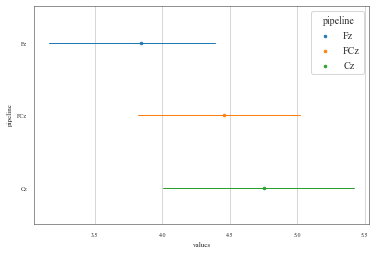

In [47]:
sns.pointplot(
    data = between_df, 
    x = 'values', 
    y='pipeline', 
    hue='pipeline',  
    orient='h', 
    join=False, 
    estimator=np.std, 
    ci=95,
    capsize=0, 
    errwidth=1,   
    scale = 0.4, 
)

In [48]:
between_df.groupby("pipeline").describe()

variance                                                        \
            count      mean           std       min       25%       50%   
pipeline                                                                  
Cz          112.0  4.754734  8.921703e-16  4.754734  4.754734  4.754734   
FCz         112.0  4.461628  8.921703e-16  4.461628  4.461628  4.461628   
Fz          112.0  3.841321  8.921703e-16  3.841321  3.841321  3.841321   

                             values                                          \
               75%       max  count      mean       std       min       25%   
pipeline                                                                      
Cz        4.754734  4.754734  112.0  5.669355  4.776104 -5.427866  2.354657   
FCz       4.461628  4.461628  112.0  2.977234  4.481681 -7.765726 -0.292950   
Fz        3.841321  3.841321  112.0  0.716676  3.858586 -8.060213 -1.926327   

                                         
               50%       75%        max  
pipeline                                 
Cz        5.820759  8.776409  19.559059  
FCz       2.693353  6.325513  16.632795  
Fz        0.523088  2.821100  13.167470

In [49]:
between_df.to_csv(f'../data/consistency_tests/{dataset}/crn_amplitude_between.csv')

### Internal Consistency of CRN amplitude

In [52]:
consistency_df = pd.DataFrame()

In [53]:
for pipeline in between_df['pipeline'].unique().tolist():
    
    between_std = np.std(np.array(between_df.loc[between_df['pipeline'] == pipeline, 'values'].tolist())) 
    print(between_std)
    within_list = np.array(within_df.loc[within_df['pipeline'] == pipeline, 'personal variance'].tolist())
    num_trials_list = np.array(within_df.loc[within_df['pipeline'] == pipeline, 'num_trials'].tolist())
    ids = np.array(within_df.loc[within_df['pipeline'] == pipeline, 'id'].tolist())
        
    for person_variance, num_trials, id in zip(within_list, num_trials_list, ids):
        
        internal_consistency = between_std**2/(between_std**2 + (person_variance**2/num_trials))    
        data = pd.DataFrame({
            'pipeline' : [pipeline],
            'id':id,
            'internal_variance' : [internal_consistency],
        })
    
        consistency_df = pd.concat([consistency_df, data], ignore_index=True)

3.8413211207835647
4.461628317563266
4.754734460533745


In [54]:
consistency_df

,pipeline,id,internal_variance
0,Fz,024,0.953654
1,Fz,187,0.978319
2,Fz,132,0.986299
3,Fz,077,0.973054
4,Fz,154,0.978580
...,...,...,...
331,Cz,AP0706,0.980474
332,Cz,MD2903,0.989484
333,Cz,MW1710,0.987502
334,Cz,RS0303,0.989598


In [55]:
consistency_df.groupby("pipeline").describe()

internal_variance                                                    \
                     count      mean       std       min       25%       50%   
pipeline                                                                       
Cz                   112.0  0.983873  0.005594  0.965833  0.980801  0.984193   
FCz                  112.0  0.980119  0.006744  0.960268  0.976178  0.980919   
Fz                   112.0  0.976423  0.008346  0.949901  0.970578  0.977188   

                              
               75%       max  
pipeline                      
Cz        0.987935  0.992538  
FCz       0.985525  0.990824  
Fz        0.983343  0.990795

In [56]:
consistency_df.to_csv(f'../data/consistency_tests/{dataset}/crn_amplitude_consistency.csv')

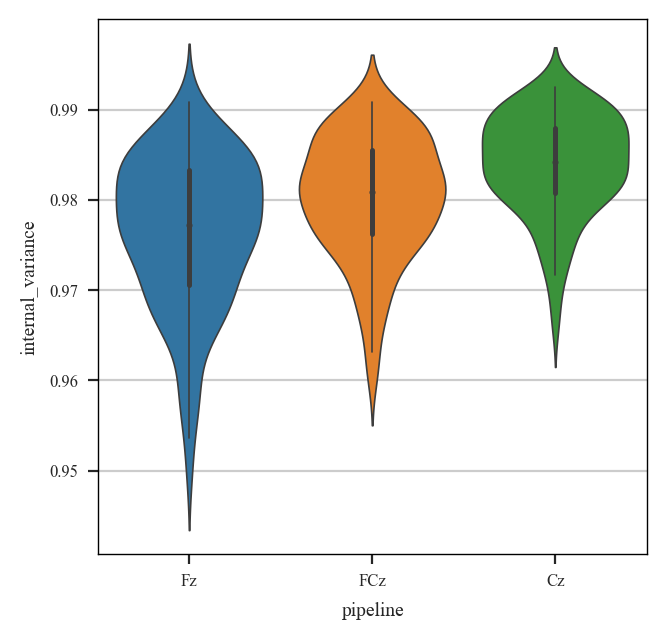

In [57]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('colorblind')

ax = sns.violinplot(
    x = 'pipeline', 
    y = 'internal_variance', 
    data = consistency_df, 
    orient='v',  
    inner="box", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
    # palette=colors,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

### Within subject variability of ERN amplitude

In [ ]:
within_df = pd.DataFrame()
rois = [["Fz"],["FCz"], ["Cz"]]

for index, roi in enumerate(rois):
    pipeline_name = f'{roi[0]}'

    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    
    ern_pipeline = Pipeline([
            ("lowpass", BandpassFilter(h_freq=40.0)),
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("trim", EpochTrim(tmin=0, tmax=0.1)),
            ('extract_epoch_data', ExtractDataEpochs(condition='error_response')),
            ("mean_amplitude", AverageSignal()),
    ])

    # for each person in dataset
    for index in range(0, len(epochs_df_copy)):
        data = epochs_df_copy.iloc[[index]] # df
        id_ = data['id'].to_list()
        personal_X = ern_pipeline.fit_transform(data) * 1000000
        personal_X = personal_X.reshape(-1,1)
        personal_variance = np.std(personal_X.flatten())

        data = pd.DataFrame({
            'pipeline' : pipeline_name,
            'id':id_,
            'personal variance' : personal_variance,
            'num_trials': len(personal_X),
        })

        within_df = pd.concat([within_df, data], ignore_index = True)

In [59]:
within_df.head()

,pipeline,id,personal variance,num_trials
0,Fz,024,15.892717,15
1,Fz,187,8.796508,48
2,Fz,132,7.231211,21
3,Fz,077,10.252945,19
4,Fz,154,10.071418,45


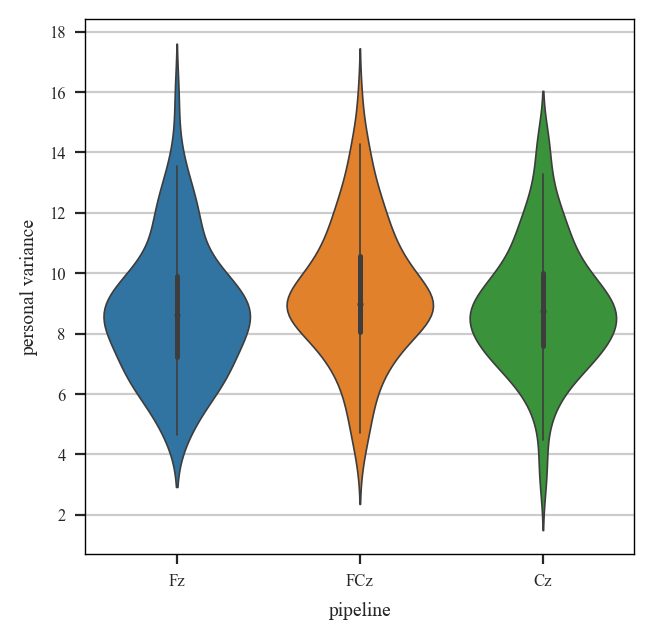

In [60]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('colorblind')

ax = sns.violinplot(
    x = 'pipeline', 
    y = 'personal variance', 
    data = within_df, 
    orient='v',  
    inner="box", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

In [61]:
within_df.groupby("pipeline").describe()

personal variance                                                    \
                     count      mean       std       min       25%       50%   
pipeline                                                                       
Cz                   112.0  8.892469  2.080489  3.114836  7.603998  8.755204   
FCz                  112.0  9.360737  2.201566  4.075858  8.042928  8.990639   
Fz                   112.0  8.718295  2.195545  4.633738  7.214156  8.627600   

                               num_trials                                   \
                75%        max      count       mean        std  min   25%   
pipeline                                                                     
Cz        10.020727  14.421179      112.0  25.857143  14.121007  6.0  16.0   
FCz       10.556407  15.736128      112.0  25.857143  14.121007  6.0  16.0   
Fz         9.926855  15.892717      112.0  25.857143  14.121007  6.0  16.0   

                            
           50%   75%   max  
pipeline                    
Cz        22.0  34.0  79.0  
FCz       22.0  34.0  79.0  
Fz        22.0  34.0  79.0

In [62]:
within_df.to_csv(f'../data/consistency_tests/{dataset}/ern_amplitude_within.csv')

### Between-subject variability of ERN amplitude

In [ ]:
between_df = pd.DataFrame()
rois = [["Fz"],["FCz"], ["Cz"]]

for index, roi in enumerate(rois):
    pipeline_name = f'{roi[0]}'

    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    
    ern_pipeline = Pipeline([
            ("lowpass", BandpassFilter(h_freq=40.0)),
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("trim", EpochTrim(tmin=0, tmax=0.1)),
            ("average", Evoked(condition='error_response')),
            ('extract_epoch_data', ExtractData()),
            ("mean_amplitude", AverageSignal()),
    ])
    
    X = ern_pipeline.fit_transform(epochs_df_copy) * 1000000
    X = X.reshape(-1,1)
    variance = np.std(X.flatten()) 
    
    variance_list = [variance] * len(epochs_df_copy)
    pipeline_list = [pipeline_name] * len(epochs_df_copy)

    data = pd.DataFrame({
        'pipeline' : pipeline_list,
        'id': epochs_df_copy['id'].to_list(),
        'variance' : variance_list,
        'values' : X.flatten(),        
    })

    between_df = pd.concat([between_df, data], ignore_index = True)

<AxesSubplot: xlabel='values', ylabel='pipeline'>

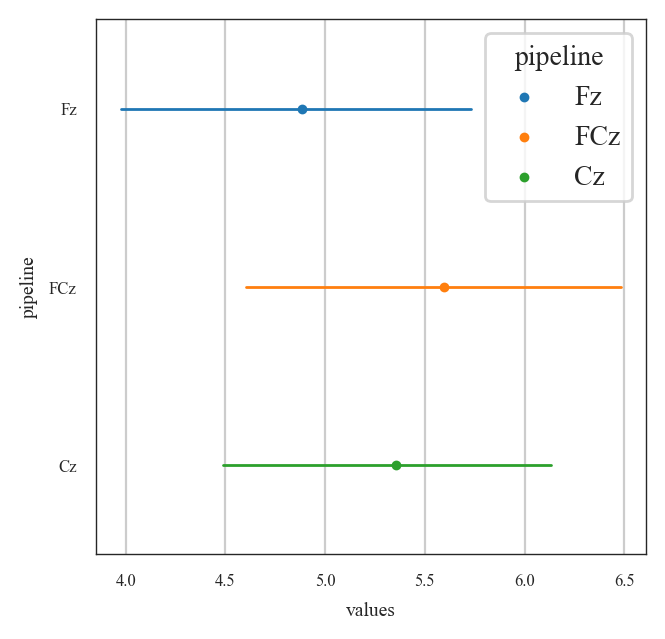

In [64]:
sns.pointplot(
    data = between_df, 
    x = 'values', 
    y='pipeline', 
    hue='pipeline',  
    orient='h', 
    join=False, 
    estimator=np.std, 
    ci=95,
    capsize=0, 
    errwidth=1,   
    scale = 0.4, 
)

In [65]:
between_df.groupby("pipeline").describe()

variance                                                        \
            count      mean           std       min       25%       50%   
pipeline                                                                  
Cz          112.0  5.353155  8.921703e-16  5.353155  5.353155  5.353155   
FCz         112.0  5.596659  0.000000e+00  5.596659  5.596659  5.596659   
Fz          112.0  4.886433  0.000000e+00  4.886433  4.886433  4.886433   

                             values                                           \
               75%       max  count      mean       std        min       25%   
pipeline                                                                       
Cz        5.353155  5.353155  112.0 -1.538221  5.377214 -20.466261 -4.106527   
FCz       5.596659  5.596659  112.0 -3.725317  5.621813 -23.034339 -6.633936   
Fz        4.886433  4.886433  112.0 -4.199188  4.908395 -21.372954 -6.600663   

                                         
               50%       75%        max  
pipeline                                 
Cz       -1.653846  2.355777  10.456802  
FCz      -3.855167  0.031308   6.896987  
Fz       -4.460999 -1.010681   5.428111

In [66]:
between_df.to_csv(f'../data/consistency_tests/{dataset}/ern_amplitude_between.csv')

### Internal Consistency of ERN amplitude

In [67]:
consistency_df = pd.DataFrame()

In [68]:
for pipeline in between_df['pipeline'].unique().tolist():
    
    between_std = np.std(np.array(between_df.loc[between_df['pipeline'] == pipeline, 'values'].tolist())) 
    print(between_std)
    within_list = np.array(within_df.loc[within_df['pipeline'] == pipeline, 'personal variance'].tolist())
    num_trials_list = np.array(within_df.loc[within_df['pipeline'] == pipeline, 'num_trials'].tolist())
    ids = np.array(within_df.loc[within_df['pipeline'] == pipeline, 'id'].tolist())
        
    for person_variance, num_trials, id in zip(within_list, num_trials_list, ids):
        
        internal_consistency = between_std**2/(between_std**2 + (person_variance**2/num_trials))    
        data = pd.DataFrame({
            'pipeline' : [pipeline],
            'id': id,
            'internal_variance' : [internal_consistency],
        })
    
        consistency_df = pd.concat([consistency_df, data], ignore_index=True)

4.886432976059901
5.596659290815888
5.353154922614804


In [69]:
consistency_df.groupby("pipeline").describe()

internal_variance                                                    \
                     count      mean       std       min       25%       50%   
pipeline                                                                       
Cz                   112.0  0.879214  0.071815  0.669400  0.840433  0.899167   
FCz                  112.0  0.877497  0.073941  0.654860  0.837423  0.905263   
Fz                   112.0  0.864228  0.082935  0.586437  0.816413  0.887882   

                              
               75%       max  
pipeline                      
Cz        0.931176  0.980829  
FCz       0.933408  0.982145  
Fz        0.923829  0.976120

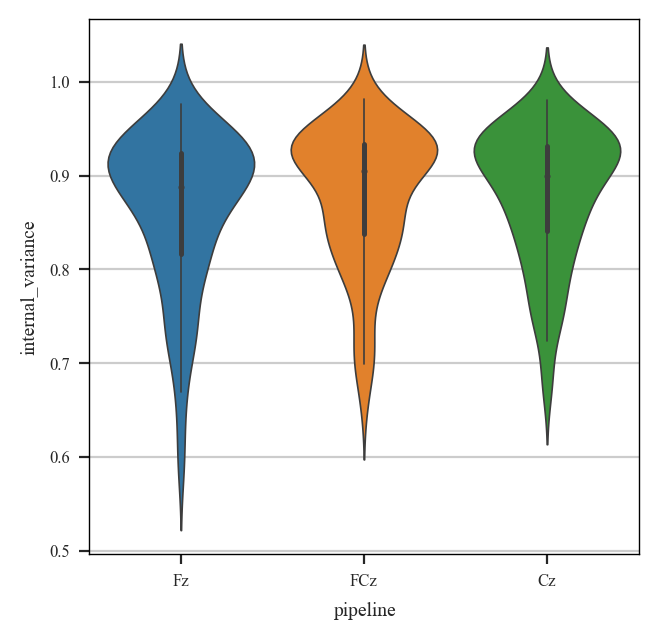

In [70]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('colorblind')

ax = sns.violinplot(
    x = 'pipeline', 
    y = 'internal_variance', 
    data = consistency_df, 
    orient='v',  
    inner="box", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
    # palette=colors,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

In [71]:
consistency_df.to_csv(f'../data/consistency_tests/{dataset}/ern_amplitude_consistency.csv')

---

## Latency

In [61]:
class FractionalAreaLatency2(TransformerMixin, BaseEstimator):
    def __init__(self, fraction = 0.5, tmin = 0.0, tmax = 0.5, threshold = 0.0):
        self.fraction=fraction,
        self.tmin=tmin,
        self.tmax=tmax,
        self.threshold=threshold

    def fractional_negative_area_latency(self, signal):
        x = np.linspace(self.tmin[0], self.tmax[0], num=signal.shape[-1])
        y = signal.flatten()
        
        # get only negative part of signal
        y_negative = [abs(y_item) if y_item < self.threshold else 0 for y_item in y]
        
        # calculate area under the signal
        area = abs(simpson(y_negative, x))
        
        if area != 0.0:
            fractional_area = area * self.fraction[0]
        
            # search for latency point (x) which split area according to fraction provided 
            current_area = 0
            fractional_area_index = 0
            i = 2
            while abs(simpson(y_negative[:i], x[:i])) <= fractional_area:
                current_area = abs(simpson(y_negative[:i], x[:i]))
                fractional_area_index = i
                i+=1
            return (fractional_area_index, x[fractional_area_index])    
        else:
            print('No area detected')
            return (np.nan, np.nan) 
         
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if len(X.shape) != 3:
            X=X[0]
        fractional_area_latencies = np.array([self.fractional_negative_area_latency(this_signal)[1] for this_signal in X])
        return fractional_area_latencies

ERN parameters

In [62]:
tmin = -0.05
tmax = 0.2
threshold = 1*1e-6

### Within subject variability of ERN latency

In [63]:
within_latency_df = pd.DataFrame()
rois = [["Fz"], ["FCz"], ["Cz"]]

for index, roi in enumerate(rois):
    pipeline_name = f'{roi[0]}'

    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    
    ern_pipeline = Pipeline([
            ("lowpass", BandpassFilter(h_freq=40.0)),
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
            ('extract_epoch_data', ExtractDataEpochs(condition='error_response')),
            ("latency", FractionalAreaLatency2(tmin=tmin, tmax=tmax, threshold=threshold)),
    ])

    # for each person in dataset calculate the latency of single trials
    for index in range(0, len(epochs_df_copy)):
        data = epochs_df_copy.iloc[[index]] # df
        id_ = data['id'].to_list()
        personal_X = ern_pipeline.fit_transform(data)
        personal_X = personal_X.reshape(-1,1)
        personal_variance = np.nanstd(personal_X.flatten())

        data = pd.DataFrame({
            'pipeline' : pipeline_name,
            'id':id_,
            'personal variance' : personal_variance,
            'num_trials': len(personal_X),
        })

        within_latency_df = pd.concat([within_latency_df, data], ignore_index = True)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No area detected
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No area detected
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No area detected
No area detected
No area detected
NOTE: pick_channels() is a legacy f

In [64]:
within_latency_df.head()

,pipeline,id,personal variance,num_trials
0,Fz,024,0.046559,15
1,Fz,187,0.047375,48
2,Fz,132,0.044204,21
3,Fz,077,0.048743,19
4,Fz,154,0.029274,45


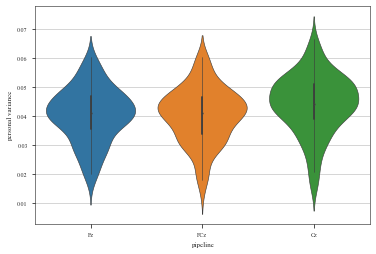

In [65]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('colorblind')

ax = sns.violinplot(
    x = 'pipeline', 
    y = 'personal variance', 
    data = within_latency_df, 
    orient='v',  
    inner="box", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

In [66]:
within_latency_df.groupby("pipeline").describe()

personal variance                                                    \
                     count      mean       std       min       25%       50%   
pipeline                                                                       
Cz                   112.0  0.044128  0.010248  0.015249  0.038803  0.044093   
FCz                  112.0  0.040248  0.009591  0.013615  0.033756  0.041054   
Fz                   112.0  0.040390  0.009434  0.016680  0.035399  0.041062   

                             num_trials                                   \
               75%       max      count       mean        std  min   25%   
pipeline                                                                   
Cz        0.051092  0.066348      112.0  25.857143  14.121007  6.0  16.0   
FCz       0.046345  0.060325      112.0  25.857143  14.121007  6.0  16.0   
Fz        0.046685  0.060172      112.0  25.857143  14.121007  6.0  16.0   

                            
           50%   75%   max  
pipeline                    
Cz        22.0  34.0  79.0  
FCz       22.0  34.0  79.0  
Fz        22.0  34.0  79.0

In [67]:
within_latency_df.to_csv(f'../new_results/consistency_tests/{dataset}/ern_latency_within.csv')

### Between-subject variability of ERN latency

In [68]:
between_latency_df = pd.DataFrame()
rois = [["Fz"],["FCz"], ["Cz"]]

for index, roi in enumerate(rois):
    pipeline_name = f'{roi[0]}'

    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    
    ern_pipeline = Pipeline([
            ("lowpass", BandpassFilter(h_freq=40.0)),
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
            ("average", Evoked(condition='error_response')),
            ('extract_epoch_data', ExtractData()),
            ("latency", FractionalAreaLatency2(tmin=tmin, tmax=tmax, threshold=threshold)),
    ])
    
    X = ern_pipeline.fit_transform(epochs_df_copy)
    print(X.shape)
    X = X.reshape(-1,1)
    variance = np.nanstd(X.flatten()) 
    
    variance_list = [variance] * len(epochs_df_copy)
    pipeline_list = [pipeline_name] * len(epochs_df_copy)

    data = pd.DataFrame({
        'pipeline' : pipeline_list,
        'id': epochs_df_copy['id'].to_list(),
        'variance' : variance_list,
        'values' : X.flatten(),        
    })

    between_latency_df = pd.concat([between_latency_df, data], ignore_index = True)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

<AxesSubplot: xlabel='values', ylabel='pipeline'>

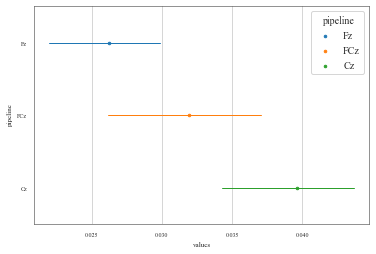

In [69]:
sns.pointplot(
    data = between_latency_df, 
    x = 'values', 
    y='pipeline', 
    hue='pipeline',  
    orient='h', 
    join=False, 
    estimator=np.std, 
    ci=95,
    capsize=0, 
    errwidth=1,   
    scale = 0.4, 
)

In [70]:
between_latency_df.groupby("pipeline").describe()

variance                                                        \
            count      mean           std       min       25%       50%   
pipeline                                                                  
Cz          112.0  0.039645  6.970080e-18  0.039645  0.039645  0.039645   
FCz         112.0  0.031948  0.000000e+00  0.031948  0.031948  0.031948   
Fz          112.0  0.026228  1.045512e-17  0.026228  0.026228  0.026228   

                             values                                          \
               75%       max  count      mean       std       min       25%   
pipeline                                                                      
Cz        0.039645  0.039645  111.0  0.041814  0.039825 -0.050000  0.020312   
FCz       0.031948  0.031948  112.0  0.045598  0.032092 -0.050000  0.031055   
Fz        0.026228  0.026228  112.0  0.051214  0.026345 -0.022656  0.039844   

                                        
               50%       75%       max  
pipeline                                
Cz        0.051562  0.071094  0.110156  
FCz       0.049609  0.063281  0.137500  
Fz        0.051562  0.064258  0.133594

In [71]:
between_latency_df.to_csv(f'../new_results/consistency_tests/{dataset}/ern_latency_between.csv')

### Internal Consistency of ERN latency

In [72]:
consistency_latency_df = pd.DataFrame()

In [73]:
for pipeline in between_latency_df['pipeline'].unique().tolist():
    
    between_std = np.nanstd(np.array(between_latency_df.loc[between_latency_df['pipeline'] == pipeline, 'values'].tolist())) 
    print(between_std)
    within_list = np.array(within_latency_df.loc[within_latency_df['pipeline'] == pipeline, 'personal variance'].tolist())
    num_trials_list = np.array(within_latency_df.loc[within_latency_df['pipeline'] == pipeline, 'num_trials'].tolist())
        
    for person_variance, num_trials in zip(within_list, num_trials_list):
        
        internal_consistency = between_std**2/(between_std**2 + (person_variance**2/num_trials))    
        data = pd.DataFrame({'pipeline' : [pipeline],
                'internal_variance' : [internal_consistency],
        })
    
        consistency_latency_df = pd.concat([consistency_latency_df, data], ignore_index=True)

0.026227585812668416
0.03194828710805802
0.03964540406849463


In [74]:
consistency_latency_df.groupby("pipeline").describe()

internal_variance                                                    \
                     count      mean       std       min       25%       50%   
pipeline                                                                       
Cz                   112.0  0.942284  0.034730  0.822547  0.919291  0.949986   
FCz                  112.0  0.927346  0.044925  0.755497  0.910493  0.940767   
Fz                   112.0  0.897140  0.060400  0.631169  0.871790  0.916641   

                              
               75%       max  
pipeline                      
Cz        0.967715  0.989009  
FCz       0.959543  0.983758  
Fz        0.941410  0.974281

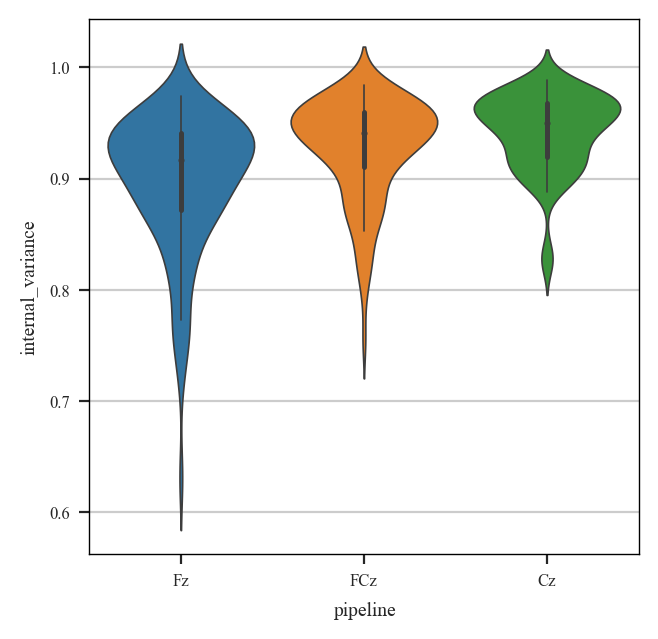

In [75]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('colorblind')

ax = sns.violinplot(
    x = 'pipeline', 
    y = 'internal_variance', 
    data = consistency_latency_df, 
    orient='v',  
    inner="box", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
    # palette=colors,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

In [76]:
consistency_latency_df.to_csv(f'../new_results/consistency_tests/{dataset}/ern_latency_consistency.csv')

CRN parameters

In [77]:
tmin = -0.05
tmax = 0.2
threshold = 2*1e-6 # threshold at 2 uV

### Within subject variability of CRN latency

In [ ]:
within_latency_df = pd.DataFrame()
rois = [["Fz"], ["FCz"], ["Cz"]]

for index, roi in enumerate(rois):
    pipeline_name = f'{roi[0]}'

    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    
    ern_pipeline = Pipeline([
            ("lowpass", BandpassFilter(h_freq=40.0)),
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
            ('extract_epoch_data', ExtractDataEpochs(condition='correct_response')),
            ("latency", FractionalAreaLatency2(tmin=tmin, tmax=tmax, threshold=threshold)),
    ])

    # for each person in dataset calculate the latency of single trials
    for index in range(0, len(epochs_df_copy)):
        data = epochs_df_copy.iloc[[index]] # df
        id_ = data['id'].to_list()
        personal_X = ern_pipeline.fit_transform(data)
        personal_X = personal_X.reshape(-1,1)
        personal_variance = np.nanstd(personal_X.flatten())

        data = pd.DataFrame({
            'pipeline' : pipeline_name,
            'id':id_,
            'personal variance' : personal_variance,
            'num_trials': len(personal_X),
        })

        within_latency_df = pd.concat([within_latency_df, data], ignore_index = True)

In [79]:
within_latency_df.head()

,pipeline,id,personal variance,num_trials
0,Fz,024,0.046006,199
1,Fz,187,0.058406,217
2,Fz,132,0.062392,217
3,Fz,077,0.051933,212
4,Fz,154,0.040783,220


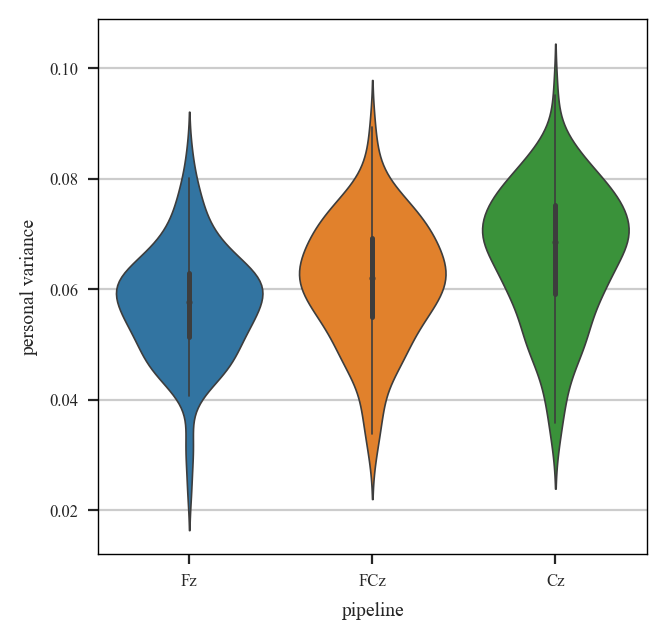

In [80]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('colorblind')

ax = sns.violinplot(
    x = 'pipeline', 
    y = 'personal variance', 
    data = within_latency_df, 
    orient='v',  
    inner="box", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

In [81]:
within_latency_df.groupby("pipeline").describe()

personal variance                                                    \
                     count      mean       std       min       25%       50%   
pipeline                                                                       
Cz                   112.0  0.066289  0.012039  0.033297  0.059075  0.068502   
FCz                  112.0  0.061296  0.011023  0.030623  0.055031  0.062037   
Fz                   112.0  0.057442  0.010012  0.024209  0.051287  0.057785   

                             num_trials                                      \
               75%       max      count        mean       std   min     25%   
pipeline                                                                      
Cz        0.075232  0.095091      112.0  211.107143  17.98666  82.0  207.75   
FCz       0.069221  0.089308      112.0  211.107143  17.98666  82.0  207.75   
Fz        0.062881  0.084357      112.0  211.107143  17.98666  82.0  207.75   

                               
            50%    75%    max  
pipeline                       
Cz        217.0  221.0  224.0  
FCz       217.0  221.0  224.0  
Fz        217.0  221.0  224.0

In [82]:
within_latency_df.to_csv(f'../new_results/consistency_tests/{dataset}/crn_latency_within.csv')

### Between-subject variability of CRN latency

In [ ]:
between_latency_df = pd.DataFrame()
rois = [["Fz"],["FCz"], ["Cz"]]

for index, roi in enumerate(rois):
    pipeline_name = f'{roi[0]}'

    epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))
    
    ern_pipeline = Pipeline([
            ("lowpass", BandpassFilter(h_freq=40.0)),
            ("channels_extraction",PickChannels(channels_list=roi)),
            ("trim", EpochTrim(tmin=tmin, tmax=tmax)),
            ("average", Evoked(condition='correct_response')),
            ('extract_epoch_data', ExtractData()),
            ("latency", FractionalAreaLatency2(tmin=tmin, tmax=tmax, threshold=threshold)),
    ])
    
    X = ern_pipeline.fit_transform(epochs_df_copy)
    print(X.shape)
    X = X.reshape(-1,1)
    variance = np.nanstd(X.flatten()) 
    
    variance_list = [variance] * len(epochs_df_copy)
    pipeline_list = [pipeline_name] * len(epochs_df_copy)

    data = pd.DataFrame({
        'pipeline' : pipeline_list,
        'id': epochs_df_copy['id'].to_list(),
        'variance' : variance_list,
        'values' : X.flatten(),        
    })

    between_latency_df = pd.concat([between_latency_df, data], ignore_index = True)

<AxesSubplot: xlabel='values', ylabel='pipeline'>

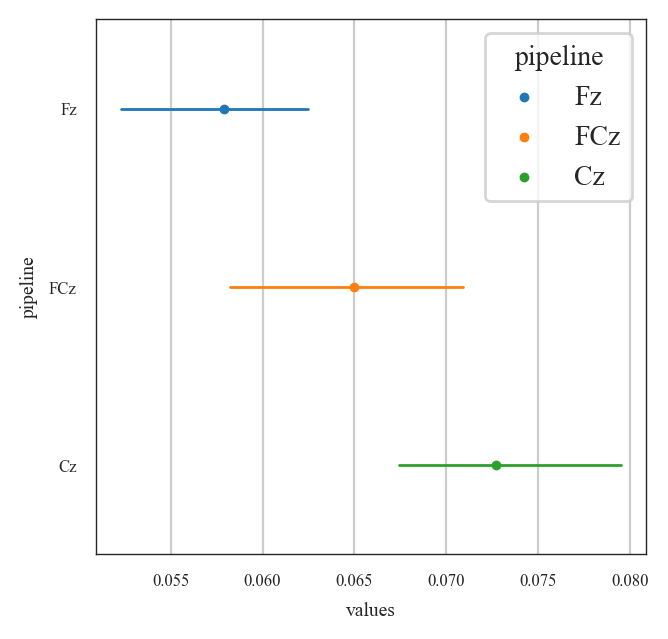

In [84]:
sns.pointplot(
    data = between_latency_df, 
    x = 'values', 
    y='pipeline', 
    hue='pipeline',  
    orient='h', 
    join=False, 
    estimator=np.std, 
    ci=95,
    capsize=0, 
    errwidth=1,   
    scale = 0.4, 
)

In [85]:
between_latency_df.groupby("pipeline").describe()

variance                                                        \
            count      mean           std       min       25%       50%   
pipeline                                                                  
Cz          112.0  0.072716  1.394016e-17  0.072716  0.072716  0.072716   
FCz         112.0  0.064999  1.394016e-17  0.064999  0.064999  0.064999   
Fz          112.0  0.057906  6.970080e-18  0.057906  0.057906  0.057906   

                             values                                      \
               75%       max  count      mean       std   min       25%   
pipeline                                                                  
Cz        0.072716  0.072716  109.0  0.030920  0.073052 -0.05 -0.026563   
FCz       0.064999  0.064999  110.0  0.048402  0.065297 -0.05 -0.010938   
Fz        0.057906  0.057906  111.0  0.078906  0.058168 -0.05  0.028125   

                                        
               50%       75%       max  
pipeline                                
Cz        0.000781  0.098437  0.184375  
FCz       0.033984  0.105273  0.176563  
Fz        0.090625  0.127734  0.180469

In [86]:
between_latency_df.to_csv(f'../new_results/consistency_tests/{dataset}/crn_latency_between.csv')

### Internal Consistency of CRN latency

In [87]:
consistency_latency_df = pd.DataFrame()

In [88]:
for pipeline in between_latency_df['pipeline'].unique().tolist():
    
    between_std = np.nanstd(np.array(between_latency_df.loc[between_latency_df['pipeline'] == pipeline, 'values'].tolist())) 
    print(between_std)
    within_list = np.array(within_latency_df.loc[within_latency_df['pipeline'] == pipeline, 'personal variance'].tolist())
    num_trials_list = np.array(within_latency_df.loc[within_latency_df['pipeline'] == pipeline, 'num_trials'].tolist())
        
    for person_variance, num_trials in zip(within_list, num_trials_list):
        
        internal_consistency = between_std**2/(between_std**2 + (person_variance**2/num_trials))    
        data = pd.DataFrame({'pipeline' : [pipeline],
                'internal_variance' : [internal_consistency],
        })
    
        consistency_latency_df = pd.concat([consistency_latency_df, data], ignore_index=True)

0.05790582466248402
0.06499907689975985
0.0727164772063931


In [89]:
consistency_latency_df.groupby("pipeline").describe()

internal_variance                                                    \
                     count      mean       std       min       25%       50%   
pipeline                                                                       
Cz                   112.0  0.995899  0.001528  0.989257  0.994946  0.995901   
FCz                  112.0  0.995623  0.001583  0.990176  0.994719  0.995656   
Fz                   112.0  0.995177  0.001665  0.990315  0.994196  0.995291   

                              
               75%       max  
pipeline                      
Cz        0.996879  0.999052  
FCz       0.996658  0.998880  
Fz        0.996295  0.999118

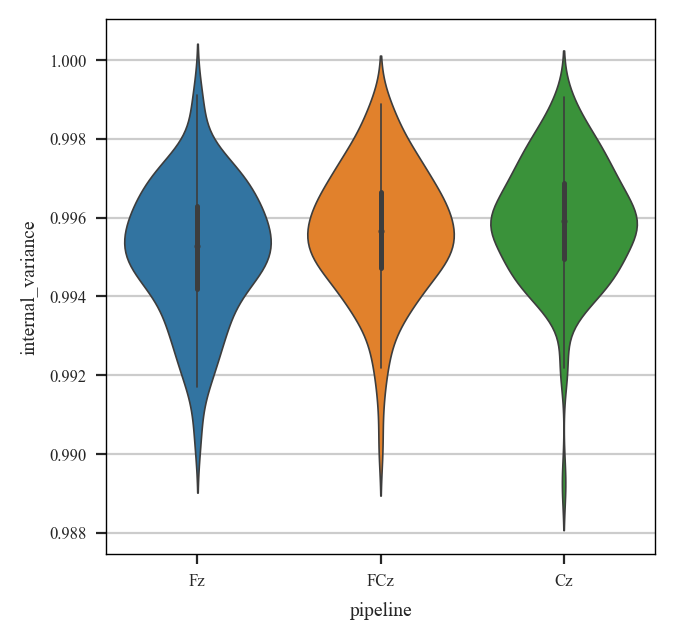

In [90]:
cm = 1/2.54
dpi = 200

sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = dpi
plt.rcParams['figure.figsize'] = [9*cm,9*cm]
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5


plt.ticklabel_format(style='sci', axis='x', scilimits=(-2,2))
plt.tick_params(axis='both', which='major', bottom=True, left = True)

pal = sns.color_palette('colorblind')

ax = sns.violinplot(
    x = 'pipeline', 
    y = 'internal_variance', 
    data = consistency_latency_df, 
    orient='v',  
    inner="box", 
    cut=2, 
    scale='width', 
    linewidth=0.6,
    # palette=colors,
)

plt.legend([],[], frameon=False)

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black') 
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')

plt.show()

# ax.figure.savefig(f"../public_data/figures/variability_supplementary_choices/internal_consistency_{condition}_dpi_{dpi}_supplementary.png",  bbox_inches='tight')

In [91]:
consistency_latency_df.to_csv(f'../new_results/consistency_tests/{dataset}/crn_latency_consistency.csv')

---
## Summary of variance tests results

### Read data

In [92]:
dataset = 'test'
test = False if dataset == 'train' else False

In [93]:
dir = f'../new_results/consistency_tests/{dataset}/'
consistencies = []

for file in sorted(glob.glob(dir + "*.csv")):
    print(file)
    consistency_df = pd.read_csv(file)
    consistencies.append(consistency_df)

../new_results/consistency_tests/test/crn_amplitude_between.csv
../new_results/consistency_tests/test/crn_amplitude_consistency.csv
../new_results/consistency_tests/test/crn_amplitude_within.csv
../new_results/consistency_tests/test/crn_latency_between.csv
../new_results/consistency_tests/test/crn_latency_consistency.csv
../new_results/consistency_tests/test/crn_latency_within.csv
../new_results/consistency_tests/test/ern_amplitude_between.csv
../new_results/consistency_tests/test/ern_amplitude_consistency.csv
../new_results/consistency_tests/test/ern_amplitude_within.csv
../new_results/consistency_tests/test/ern_latency_between.csv
../new_results/consistency_tests/test/ern_latency_consistency.csv
../new_results/consistency_tests/test/ern_latency_within.csv


### Read sample

In [94]:
results_ern_crn_lat_demo_df = pd.read_pickle(f"../data/models_pickles_new_dass/ern_crn_cov_fal_models_{dataset}_id_clean.pkl")
ids = results_ern_crn_lat_demo_df['id'].to_list()

Extract indexes of participants from sample

In [95]:
indices = consistencies[0][consistencies[0]['id'].isin(ids)].index

### Show summary

In [96]:
pipeline = 'Fz'

for consistency_measure in consistencies:
    consistency_measure = consistency_measure.iloc[indices]
    display(consistency_measure[consistency_measure['pipeline'] == pipeline].describe())
    display(consistency_measure[consistency_measure['pipeline'] == pipeline].median())

,Unnamed: 0,variance,values
count,107.000000,1.070000e+02,107.000000
mean,55.289720,3.841321e+00,0.751448
std,31.887186,8.923581e-16,3.904831
min,1.000000,3.841321e+00,-8.060213
25%,27.500000,3.841321e+00,-1.796893
50%,56.000000,3.841321e+00,0.490281
75%,82.500000,3.841321e+00,3.084840
max,110.000000,3.841321e+00,13.167470


Unnamed: 0    56.000000
variance       3.841321
values         0.490281
dtype: float64

,Unnamed: 0,internal_variance
count,107.000000,107.000000
mean,55.289720,0.976823
std,31.887186,0.008172
min,1.000000,0.949901
25%,27.500000,0.971513
50%,56.000000,0.977551
75%,82.500000,0.983560
max,110.000000,0.990795


Unnamed: 0           56.000000
internal_variance     0.977551
dtype: float64

,Unnamed: 0,personal variance,num_trials
count,107.000000,107.000000,107.000000
mean,55.289720,8.492355,212.308411
std,31.887186,1.535464,13.322850
min,1.000000,5.466874,138.000000
25%,27.500000,7.303701,208.500000
50%,56.000000,8.423905,217.000000
75%,82.500000,9.370619,221.000000
max,110.000000,13.114533,224.000000


Unnamed: 0            56.000000
personal variance      8.423905
num_trials           217.000000
dtype: float64

,Unnamed: 0,variance,values
count,107.000000,1.070000e+02,106.000000
mean,55.289720,5.790582e-02,0.079201
std,31.887186,1.394310e-17,0.058056
min,1.000000,5.790582e-02,-0.050000
25%,27.500000,5.790582e-02,0.030078
50%,56.000000,5.790582e-02,0.090625
75%,82.500000,5.790582e-02,0.128711
max,110.000000,5.790582e-02,0.180469


Unnamed: 0    56.000000
variance       0.057906
values         0.090625
dtype: float64

,Unnamed: 0,internal_variance
count,107.000000,107.000000
mean,55.289720,0.995154
std,31.887186,0.001654
min,1.000000,0.990315
25%,27.500000,0.994193
50%,56.000000,0.995239
75%,82.500000,0.996228
max,110.000000,0.999118


Unnamed: 0           56.000000
internal_variance     0.995239
dtype: float64

,Unnamed: 0,personal variance,num_trials
count,107.000000,107.000000,107.000000
mean,55.289720,0.057845,212.308411
std,31.887186,0.010021,13.322850
min,1.000000,0.024209,138.000000
25%,27.500000,0.052156,208.500000
50%,56.000000,0.058354,217.000000
75%,82.500000,0.062952,221.000000
max,110.000000,0.084357,224.000000


Unnamed: 0            56.000000
personal variance      0.058354
num_trials           217.000000
dtype: float64

,Unnamed: 0,variance,values
count,107.000000,1.070000e+02,107.000000
mean,55.289720,4.886433e+00,-4.150575
std,31.887186,8.923581e-16,4.950306
min,1.000000,4.886433e+00,-21.372954
25%,27.500000,4.886433e+00,-6.360114
50%,56.000000,4.886433e+00,-4.308205
75%,82.500000,4.886433e+00,-0.913185
max,110.000000,4.886433e+00,5.428111


Unnamed: 0    56.000000
variance       4.886433
values        -4.308205
dtype: float64

,Unnamed: 0,internal_variance
count,107.000000,107.000000
mean,55.289720,0.874921
std,31.887186,0.067522
min,1.000000,0.700168
25%,27.500000,0.832925
50%,56.000000,0.888771
75%,82.500000,0.924926
max,110.000000,0.976120


Unnamed: 0           56.000000
internal_variance     0.888771
dtype: float64

,Unnamed: 0,personal variance,num_trials
count,107.000000,107.000000,107.000000
mean,55.289720,8.554914,26.551402
std,31.887186,2.041570,14.051276
min,1.000000,4.633738,8.000000
25%,27.500000,7.155058,17.000000
50%,56.000000,8.465364,22.000000
75%,82.500000,9.713205,34.000000
max,110.000000,14.340377,79.000000


Unnamed: 0           56.000000
personal variance     8.465364
num_trials           22.000000
dtype: float64

,Unnamed: 0,variance,values
count,107.000000,107.000000,107.000000
mean,55.289720,0.026228,0.051307
std,31.887186,0.000000,0.026084
min,1.000000,0.026228,-0.022656
25%,27.500000,0.026228,0.039844
50%,56.000000,0.026228,0.051562
75%,82.500000,0.026228,0.065234
max,110.000000,0.026228,0.133594


Unnamed: 0    56.000000
variance       0.026228
values         0.051562
dtype: float64

,Unnamed: 0,internal_variance
count,107.000000,107.000000
mean,55.289720,0.898022
std,31.887186,0.059854
min,1.000000,0.631169
25%,27.500000,0.872663
50%,56.000000,0.917124
75%,82.500000,0.941615
max,110.000000,0.974281


Unnamed: 0           56.000000
internal_variance     0.917124
dtype: float64

,Unnamed: 0,personal variance,num_trials
count,107.000000,107.000000,107.000000
mean,55.289720,0.040830,26.551402
std,31.887186,0.009105,14.051276
min,1.000000,0.016680,8.000000
25%,27.500000,0.035762,17.000000
50%,56.000000,0.041080,22.000000
75%,82.500000,0.046933,34.000000
max,110.000000,0.060172,79.000000


Unnamed: 0           56.00000
personal variance     0.04108
num_trials           22.00000
dtype: float64